## Variational inference
We will fit a simple 1D Bayesian Linear regression
The likelihood is given by,
$$y \sim \mathcal{N}(w_0 + w_1x, 1),$$
and the prior is,
$$w_0, w_1 \sim N(0, I).$$


In [82]:
import jax.random as jr
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax.scipy.stats import norm, multivariate_normal
import jax
from flowjax.flows import MaskedAutoregressiveFlow
from flowjax.bijections import RationalQuadraticSpline
from flowjax.distributions import StandardNormal
from flowjax.train import fit_to_variational_target


# generate observed data
data_key = jr.PRNGKey(0)
w_0 = 0.5
w_1 = -0.5

n = 20
key, x_key, noise_key = jr.split(data_key, 3)
x = jr.uniform(x_key, shape=(n,)) * 4 - 2 # Train the flow variationally
y = w_0 + w_1 * x + jr.normal(noise_key, shape=(n,))

We can define our objective, via the unnormalised posterior distribution. This maps $w$ samples with an additional batch dimension to a vector of unnormalised probabilites

In [83]:
@jax.vmap
def unorm_posterior(w):
    likelihood = norm.logpdf(y, w[0] + x * w[1]).sum()
    prior = norm.logpdf(w).sum()  # Standard normal prior
    return (likelihood + prior).sum()


We define and fit the flow. Note that we set `invert=False`, which loosely speaking specifies that we prioritise faster `sample` and `sample_and_log_prob` methods for the flow, over faster `log_prob`. 

In [84]:
key, flow_key, train_key = jr.split(key, 3)

flow = MaskedAutoregressiveFlow(
    flow_key,
    base_dist=StandardNormal((2,)),
    transformer=RationalQuadraticSpline(knots=8, interval=4),
    invert=False
)

# Train the flow variationally
flow, losses = fit_to_variational_target(
    train_key,
    flow,
    unorm_posterior,
    learning_rate=1e-2,
    num_epochs=100
)

100%|██████████| 100/100 [00:13<00:00,  7.22it/s, loss=29.5]


We can now visualise the learned posterior, here comparing flow samples to samples from the ground truth posterior

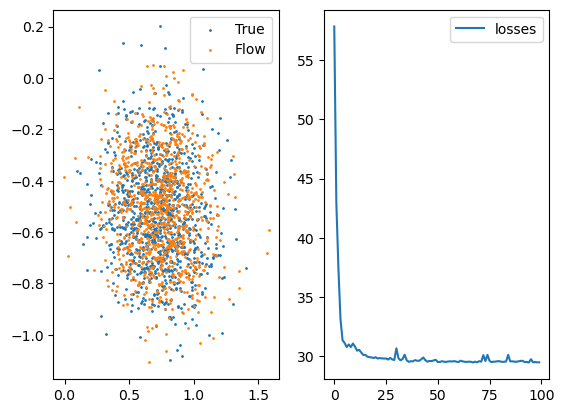

In [85]:
# True posterior for comparison
_x = jnp.vstack([jnp.ones_like(x), x]) # full design matrix
cov = jnp.linalg.inv(_x.dot(_x.T) + jnp.eye(2))
mean = cov.dot(_x).dot(y)
true_posterior_samples = jr.multivariate_normal(jr.PRNGKey(0), mean, cov, (1000,))

samples = {
    "True": true_posterior_samples,
    "Flow": flow.sample(jr.PRNGKey(0), sample_shape=(1000,))
}

fig, ax = plt.subplots(ncols=2)

for k, v in samples.items():
    ax[0].scatter(v[:, 0], v[:, 1], label=k, s=1)
ax[0].legend()

ax[1].plot(losses, label="losses")
ax[1].legend()

We can visualise the regression fits

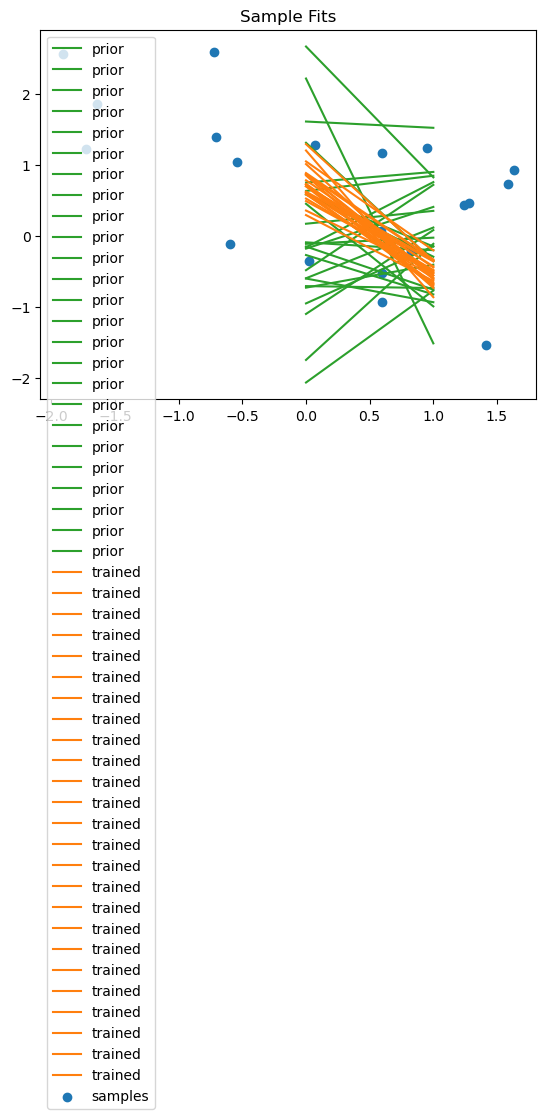

In [88]:
x_inspect = jnp.linspace(2, -2, n)
plots = [
    ('prior', StandardNormal((2,)), 'tab:green'),
    ('trained', flow, 'tab:orange'),
]
n_samples = 25

for label, flow, colour in plots:
    w = flow.sample(flow_key, sample_shape=(n_samples,))
    for ix, (w_0, w_1) in enumerate(w):
        y_inspect = w_0 + w_1 * x_inspect
        plt.plot(x_inspect, y_inspect, alpha=0.3, c=colour, label=label if ix == 0 else None)
    
plt.scatter(x, y, label='samples')
plt.title('Sample Fits')
plt.legend()
plt.show()